In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# add train and test to preprocessing 
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [5]:
all_data.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001C6DF0F0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001CAB1550>]], dtype=object)

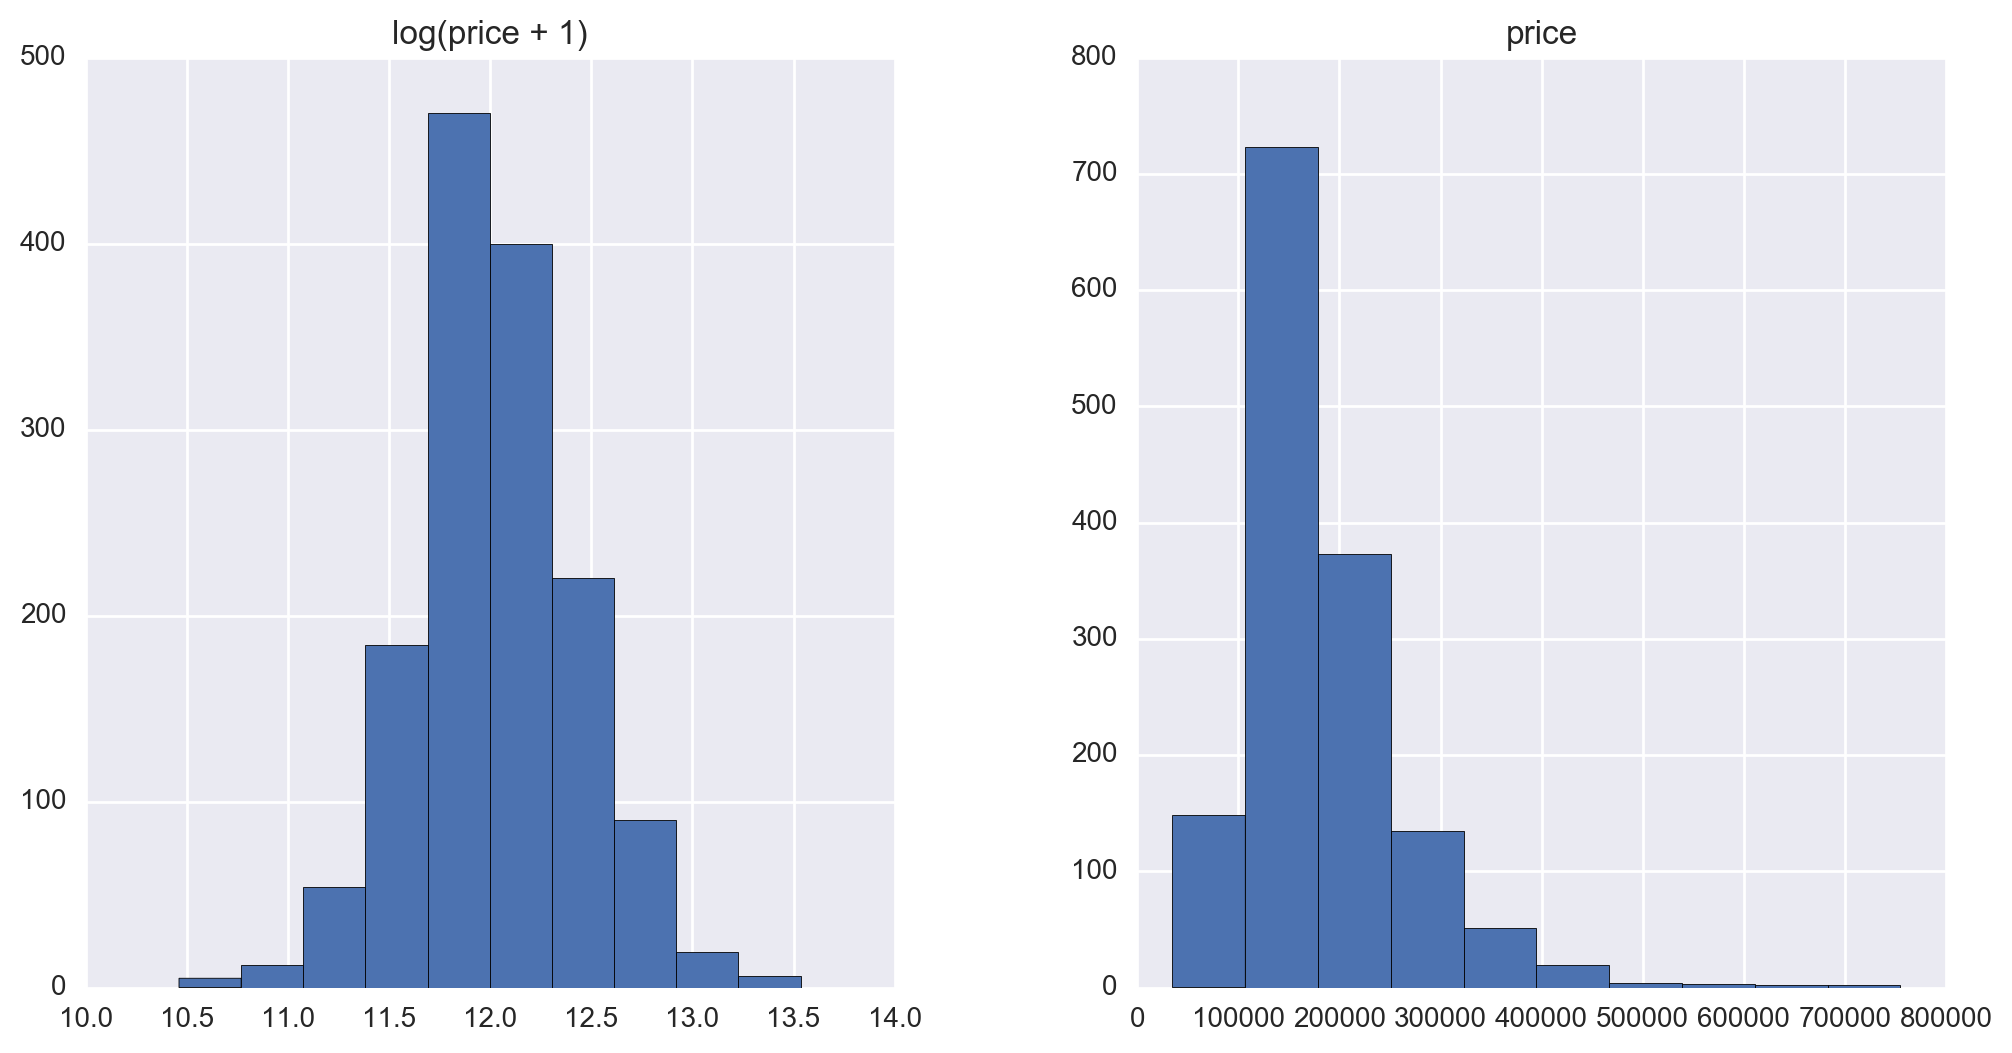

In [6]:
# observe target
# if it's skew then use log to tune it
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [7]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#search all the numeric column:
# if this column skewness is too high then transform it 
numeric_index = all_data.dtypes[all_data.dtypes != "object"].index
# some object is also numeric because data_discription says
# exclude them 
numeric_index = numeric_index.drop(['MSSubClass','OverallQual','OverallCond'])
print numeric_index
print len(numeric_index)

Index([u'LotFrontage', u'LotArea', u'YearBuilt', u'YearRemodAdd',
       u'MasVnrArea', u'BsmtFinSF1', u'BsmtFinSF2', u'BsmtUnfSF',
       u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea',
       u'BsmtFullBath', u'BsmtHalfBath', u'FullBath', u'HalfBath',
       u'BedroomAbvGr', u'KitchenAbvGr', u'TotRmsAbvGrd', u'Fireplaces',
       u'GarageYrBlt', u'GarageCars', u'GarageArea', u'WoodDeckSF',
       u'OpenPorchSF', u'EnclosedPorch', u'3SsnPorch', u'ScreenPorch',
       u'PoolArea', u'MiscVal', u'MoSold', u'YrSold'],
      dtype='object')
33


In [8]:
# compute skewness
skewed_index = train[numeric_index].apply(lambda x: skew(x.dropna())) #compute skewness
print skewed_index
print len(skewed_index)

LotFrontage       2.160866
LotArea          12.195142
YearBuilt        -0.612831
YearRemodAdd     -0.503044
MasVnrArea        2.666326
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtUnfSF         0.919323
TotalBsmtSF       1.522688
1stFlrSF          1.375342
2ndFlrSF          0.812194
LowQualFinSF      9.002080
GrLivArea         1.365156
BsmtFullBath      0.595454
BsmtHalfBath      4.099186
FullBath          0.036524
HalfBath          0.675203
BedroomAbvGr      0.211572
KitchenAbvGr      4.483784
TotRmsAbvGrd      0.675646
Fireplaces        0.648898
GarageYrBlt      -0.648708
GarageCars       -0.342197
GarageArea        0.179796
WoodDeckSF        1.539792
OpenPorchSF       2.361912
EnclosedPorch     3.086696
3SsnPorch        10.293752
ScreenPorch       4.117977
PoolArea         14.813135
MiscVal          24.451640
MoSold            0.211835
YrSold            0.096170
dtype: float64
33


In [9]:
skewed_index = skewed_index[skewed_index > 0.75]
skewed_index = skewed_index.index
# tune the skewed column using log
all_data[skewed_index] = np.log1p(all_data[skewed_index])

In [10]:
# change 'MSSubClass','OverallQual','OverallCond' to category
all_data[['MSSubClass','OverallQual','OverallCond']] = all_data[['MSSubClass','OverallQual','OverallCond']].astype(object)
all_data = pd.get_dummies(all_data)
all_data.head(10)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.189655,9.042040,2003,2003,5.283204,6.561031,0.000000,5.017280,6.753438,6.753438,...,0,0,0,1,0,0,0,0,1,0
1,4.394449,9.169623,1976,1976,0.000000,6.886532,0.000000,5.652489,7.141245,7.141245,...,0,0,0,1,0,0,0,0,1,0
2,4.234107,9.328212,2001,2002,5.093750,6.188264,0.000000,6.075346,6.825460,6.825460,...,0,0,0,1,0,0,0,0,1,0
3,4.110874,9.164401,1915,1970,0.000000,5.379897,0.000000,6.293419,6.629363,6.869014,...,0,0,0,1,1,0,0,0,0,0
4,4.442651,9.565284,2000,2000,5.860786,6.486161,0.000000,6.196444,7.044033,7.044033,...,0,0,0,1,0,0,0,0,1,0
5,4.454347,9.555064,1993,1995,0.000000,6.597146,0.000000,4.174387,6.680855,6.680855,...,0,0,0,1,0,0,0,0,1,0
6,4.330733,9.218804,2004,2005,5.231109,7.222566,0.000000,5.762051,7.430707,7.435438,...,0,0,0,1,0,0,0,0,1,0
7,NaN,9.247925,1973,1973,5.484797,6.756932,3.496508,5.379897,7.010312,7.010312,...,0,0,0,1,0,0,0,0,1,0
8,3.951244,8.719481,1931,1950,0.000000,0.000000,0.000000,6.859615,6.859615,6.930495,...,0,0,0,1,1,0,0,0,0,0
9,3.931826,8.912069,1939,1950,0.000000,6.747587,0.000000,4.948760,6.899723,6.982863,...,0,0,0,1,0,0,0,0,1,0


In [11]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [12]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice